In [88]:
import networkx as nx
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from collections import defaultdict
from operator import itemgetter

In [9]:
graph_nodes = [[0, 1, 2, 3], 
               [0, 1, 2, 3],
               [0, 1, 2, 3, 4],
               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


graph_edges = [[(0, 1), (1, 2), (2, 3), (3, 0)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (1,3)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (2,4), (3,4)],
               [(0,1), (0,2), (1,3), (1,4), (2,3), (3,4), (3,5), (4,5), (4,6), (5,9), (5,8), (5,6), (6,7), (7,10), (8,9), (8,10)]]

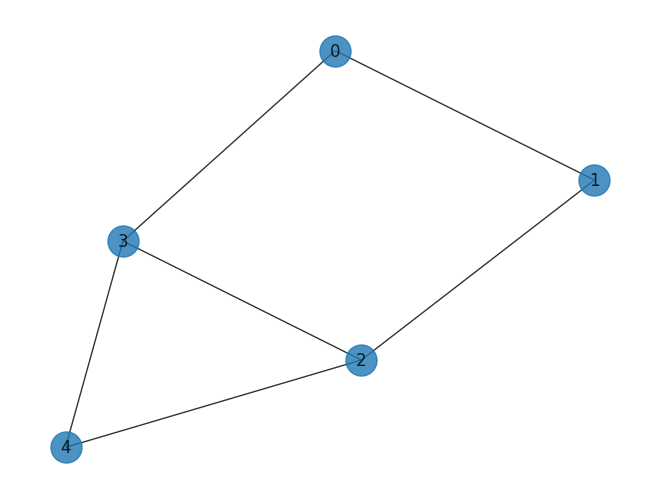

In [10]:
x = 2 # pick which graph we want to use

graph = nx.Graph()
graph.add_nodes_from(graph_nodes[x])
graph.add_edges_from(graph_edges[x])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

In [7]:
#Get weight matrix of graph
adj_matrix = nx.adjacency_matrix(graph)
size = adj_matrix.shape[0]

#Build qubo matrix Q from weight matrix W
weight_matrix = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        weight_matrix[i, j] = adj_matrix[i, j]

print(weight_matrix)

[[0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


## Min Cut Optimization problem

$$ \text{maximize } \;\;      x^{\dagger}Qx + c^{\dagger}x$$

Where Q is a n x n matrix representing the weights between nodes \
C is a n-sized vector representing total weights coming from node i \
X is a vector of our decision variables \
    $$ if x_i = -1 \;\;      \text{then } x_i \text{ belongs to partition 1}$$
    $$ if x_i = 1 \;\;      \text{then } x_i \text{ belongs to partition 2}$$

Such that:
$$ \text{minimize } \;\; \sum_{i = 1}^n x_i \text{  (try to make each partition roughly the same size)} $$


### Transform this into an unconstrainted problem

Define the penalty functino as

$$ p(x) = \text{minimize } \;\; \sum_{i = 1}^n x_i$$

New unconstrained cost function:

$$ \text{maximize } \;\;      x^{\dagger}Qx + c^{\dagger}x + \alpha p(x)^2$$

Where $\alpha$ is a scalar penalty parameter


## Constructing the problem Hamiltonian

from the above we can determing the our cost function is:

$$ C(x) = x^{\dagger}Qx + c^{\dagger}x + \alpha p(x)^2 =  \sum_{i,j = 1}^n Q_{ij} x_i x_j + \sum_{i=1}^n c_i x_i$$

Since,

$$ Z_i |x\rangle = (-1)^{Xi} = \frac{I-Z_i}{2}|x\rangle = x_i$$

### Build circuit for the cost cost operator

Cost operator $$e^{-i\gamma_pC} = e^{-i\gamma_p  (\sum_{ij \epsilon \Epsilon} (Z_i Z_j) - \sum_{i = 0}^n (Z_i Z_i))} $$

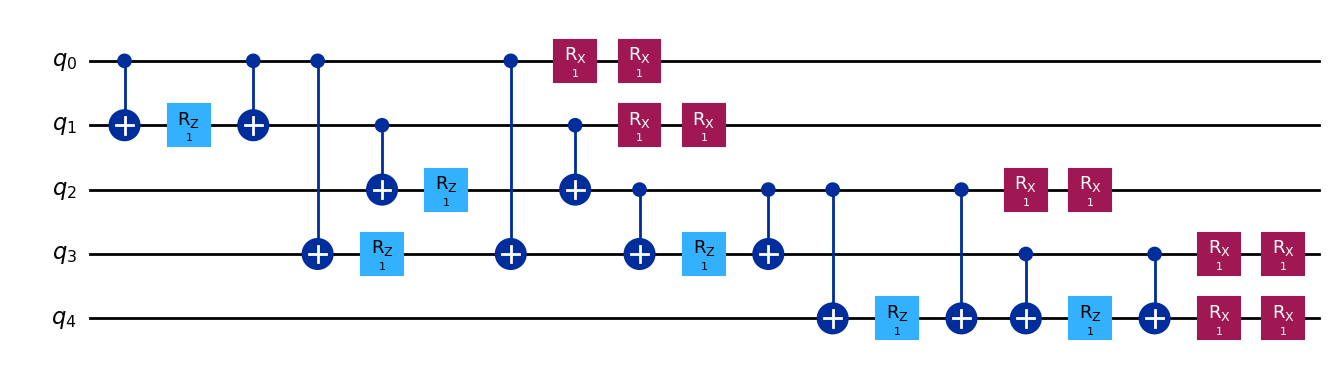

In [95]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(g, gamma):
    N = g.number_of_nodes()
    qc = QuantumCircuit(N)
    
    for i,j in g.edges():
        append_zz_term(qc, i, j, gamma)

    for n in g.nodes():
        qc.rx(2*gamma,n)
        qc.rx(2*gamma,n)   

    return qc

get_cost_operator_circuit(graph,0.5).draw('mpl')


The Mixing Unitary

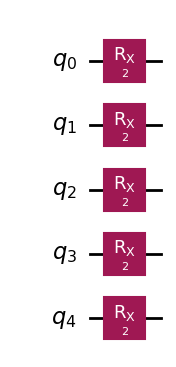

In [96]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(g, beta):
    N = g.number_of_nodes()
    qc = QuantumCircuit(N)

    for n in g.nodes():
        append_x_term(qc,n,beta)

    return qc

get_mixer_operator_circuit(graph, 1).draw('mpl')

Now build the full circuit

In [97]:
def get_qaoa_circuit(g, beta, gamma):
   assert(len(beta) == len(gamma)) 
   p = len(beta) #infering number of QAOA steps from the parameters passed
   N = g.number_of_nodes()
   qc = QuantumCircuit(N)

   #put inputs into superposition
   qc.h(range(N))

   #apply alternating operators
   for i in range(p): 
      qc.compose(get_cost_operator_circuit(g,gamma[i]), range(N), inplace=True)
      qc.compose(get_mixer_operator_circuit(g, beta[i]), range(N), inplace=True)

   #perform measurement
   qc.measure_all()

   return qc

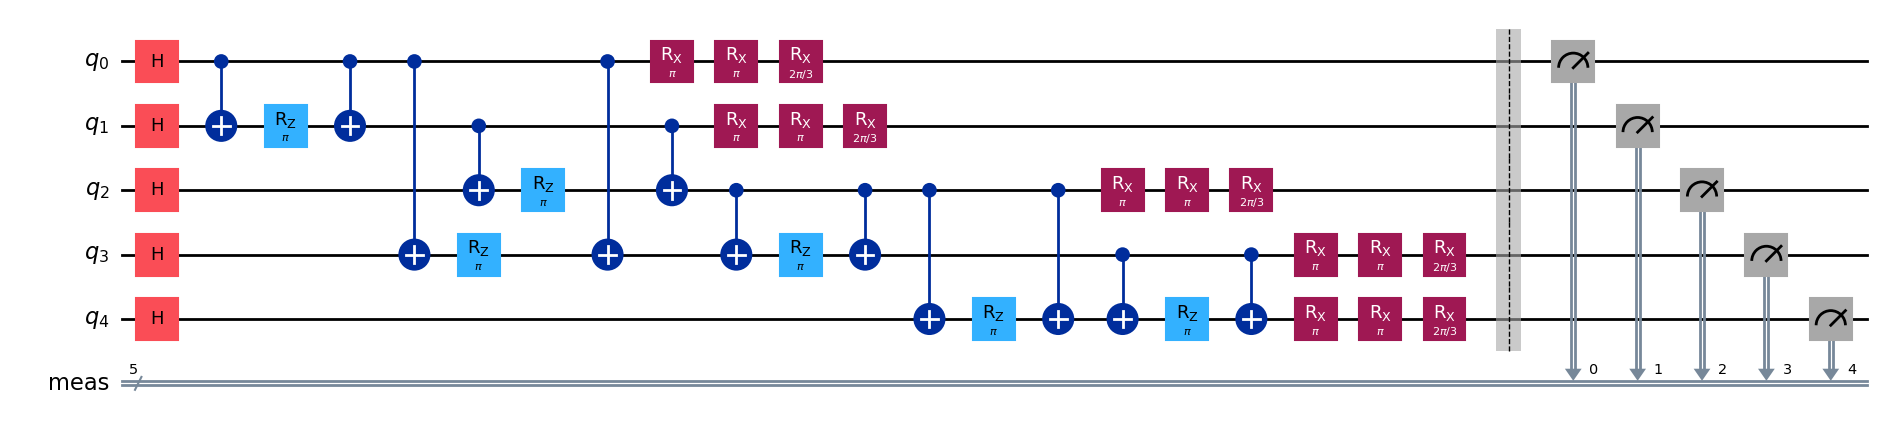

In [98]:
qc = get_qaoa_circuit(graph, [np.pi/3], [np.pi/2])
qc.draw('mpl', fold=False)

Run the circuit on the simulator

In [99]:
backend = AerSimulator()

#transpile
qc_compiled = transpile(qc, backend)

#execute the circuit 
job_sim = backend.run(qc_compiled, shots=1024)

#grab results
result_sim = job_sim.result()
print(result_sim.get_counts())

{'10100': 36, '00101': 47, '01110': 36, '01101': 31, '10101': 27, '00001': 32, '11000': 40, '10000': 38, '01000': 31, '00111': 40, '00000': 27, '01100': 37, '10010': 37, '01011': 36, '01010': 36, '00100': 28, '00010': 31, '11101': 38, '11111': 28, '01001': 16, '11011': 33, '10011': 31, '11110': 27, '01111': 34, '10110': 30, '10111': 31, '00011': 41, '11010': 36, '11100': 18, '00110': 26, '11001': 21, '10001': 24}


How good are these results?

In [100]:
#compute qaoa energy 

def mincut_obj(x,g):
    cut = 0
    for i,j in g.edges():
        if x[i] != x[j]:
            cut -= 1
    #print("Cut is " + str(cut))

    penalty = 0
    for k in x:
        if k == "0":
            penalty -= 1
        else:
            penalty += 1
    #print("Penalty is " + str(penalty**2))

    cost = cut + (penalty**2)
    #print("Total cost is " + str(cost))
    return cost

mincut_obj('00111',graph)
#mincut_obj('00000',graph)
    

-1

Estimate energy from the sample

In [101]:
def compute_mincut_energy(counts, g):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = mincut_obj(meas, g)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy/total_counts

compute_mincut_energy(result_sim.get_counts(), graph)

1.8271484375

Put all of this together

In [102]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)        
        qc_compiled = transpile(qc, backend) #transpile 
        counts = backend.run(qc_compiled, shots=1024).result().get_counts() #execute the circuit
        # return the energy
        return compute_mincut_energy(counts, G)
    return f

Run the classical optimization

In [103]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(graph, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.9658203125
       x: [ 1.669e+00  2.318e+00  7.770e-01  2.113e+00  3.479e-01
            2.428e+00  6.087e+00  2.177e+00  3.797e+00  6.225e+00]
    nfev: 96
   maxcv: 0.0

Now that we have optimized parameters, rerun quantum circuit to get solution

In [112]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(graph, optimal_theta[:p], optimal_theta[p:])
qc_compiled = transpile(qc, backend) #transpile 
job_sim = backend.run(qc_compiled, shots=1024)

counts = job_sim.result().get_counts() #execute the circuit

counts

{'11100': 229,
 '10101': 66,
 '10010': 23,
 '00011': 220,
 '01100': 55,
 '00101': 77,
 '01110': 10,
 '01111': 13,
 '00000': 5,
 '11101': 4,
 '10011': 45,
 '11010': 75,
 '01010': 85,
 '01000': 2,
 '10110': 2,
 '01001': 9,
 '10001': 15,
 '11000': 12,
 '00001': 7,
 '01101': 19,
 '11110': 8,
 '10000': 9,
 '00111': 4,
 '10100': 8,
 '00010': 6,
 '01011': 10,
 '11001': 2,
 '00100': 1,
 '00110': 3}

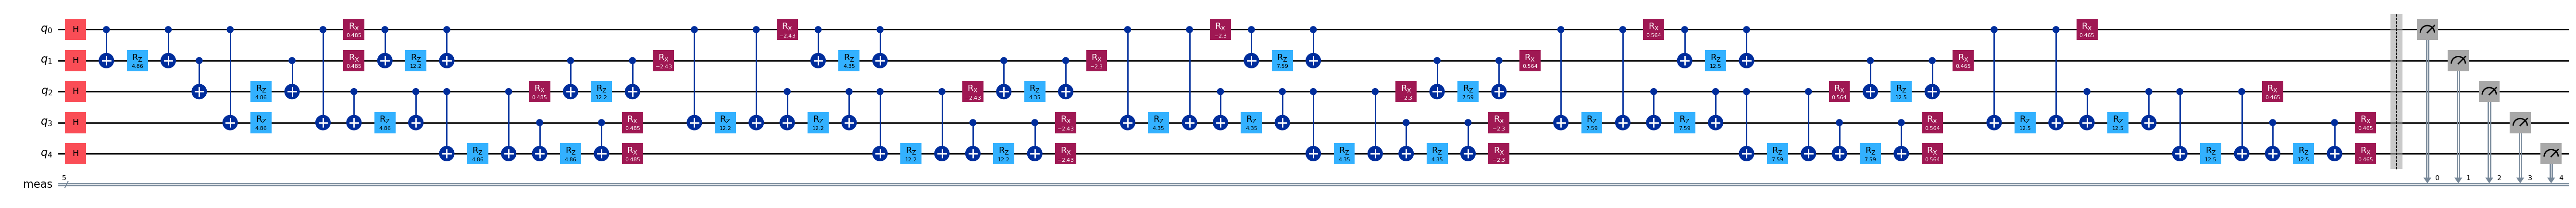

In [117]:
#show optimized circuit
qc_compiled.draw('mpl', fold=False)

In [108]:
# determine most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse() #reverse so positions in bit string match with labels on graph print("Resulting bitstring:", most_likely_bitstring)

NameError: name 'final_distribution_int' is not defined

How good are these results?

<BarContainer object of 7 artists>

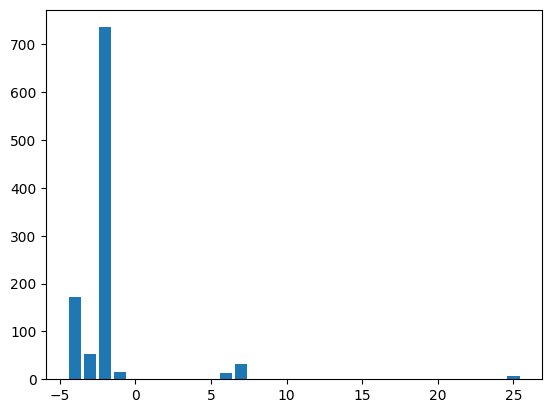

In [105]:
energies = defaultdict(int)
for k, v in counts.items():
    e = (mincut_obj(k,graph))
    energies[e] += v


x,y = zip(*energies.items())
plt.bar(x,y)

C:\Users\Ed\AppData\Local\Temp\ipykernel_37456\2754089912.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


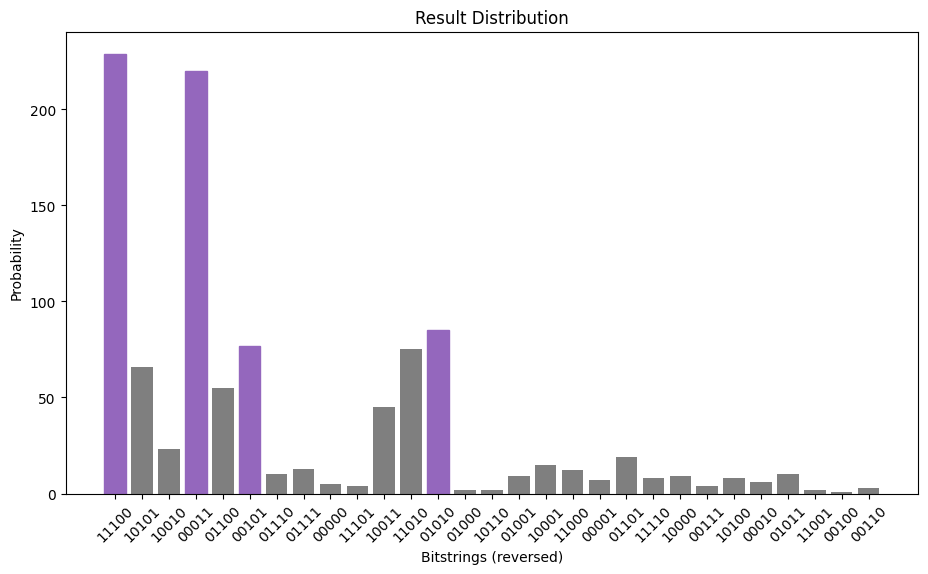

In [113]:
#show distribution
matplotlib.rcParams.update({"font.size": 10})
final_bits = counts
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]

positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")

ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
    
plt.show()

Best string: 10101 with cut: 4


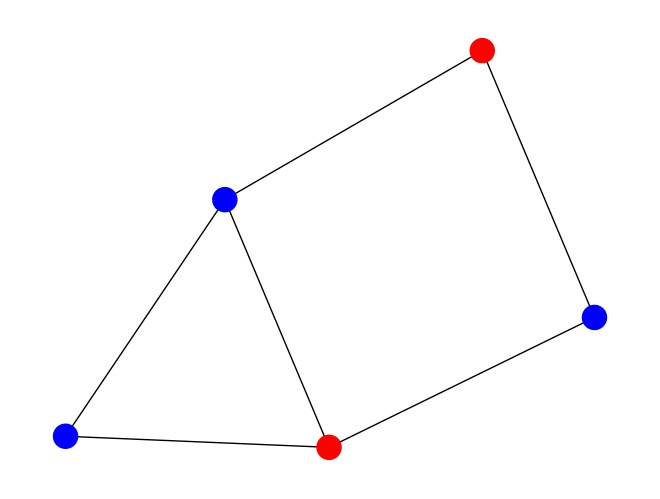

In [107]:
# get the best solution:
best_cut, best_solution = min([(mincut_obj(x,graph),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in graph]
nx.draw(graph,node_color = colors) 

I think I can removed everything below here

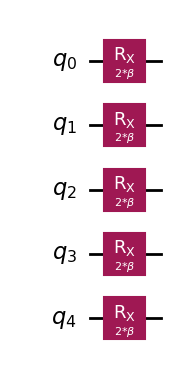

In [27]:
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = len(graph.nodes())

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw('mpl')

The Problem Unitary

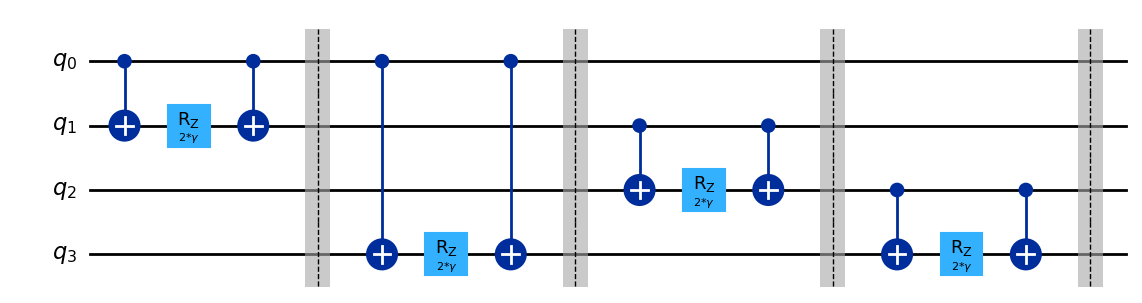

In [8]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes per egde
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw('mpl',fold=False, idle_wires=False)

The Initial State - put into superposition

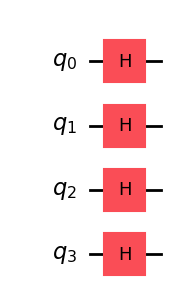

In [9]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw('mpl')

The QAOA Circuit

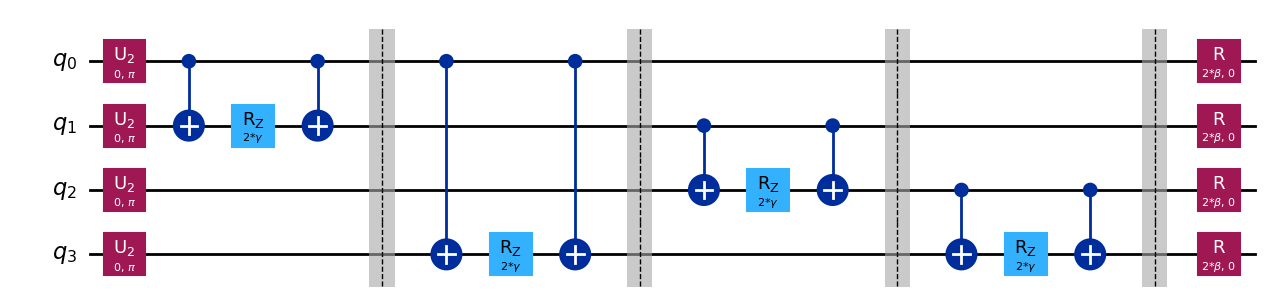

In [10]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl',fold=False, idle_wires=False)

In [31]:
def cut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    cut = 0
    partition_sum = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            cut += 1 

    for k in solution:
        if k == 0:
            partition_sum += 1
        else:
            partition_sum -= -1

    partition_sum = abs(partition_sum) # make 
    
    obj = cut + partition_sum**2

    return obj

In [13]:

def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = cut_obj(bit_string, graph)
        #print(str(bit_string) + ":" + str(obj))
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [14]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc

In [20]:
objective_func_vals = [] 

#Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        cost = compute_expectation(counts, graph)
        objective_func_vals.append(cost) 
        return cost

    return execute_circ

In [32]:
from scipy.optimize import minimize

objective_func_vals = []
expectation = get_expectation(graph)
print(expectation)

res = minimize(expectation,
               [np.pi, np.pi/2],
               method='COBYLA',
               tol=1e-2)
res

<function get_expectation.<locals>.execute_circ at 0x00000223436FF380>


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 27.9833984375
       x: [ 3.142e+00  1.571e+00]
    nfev: 7
   maxcv: 0.0

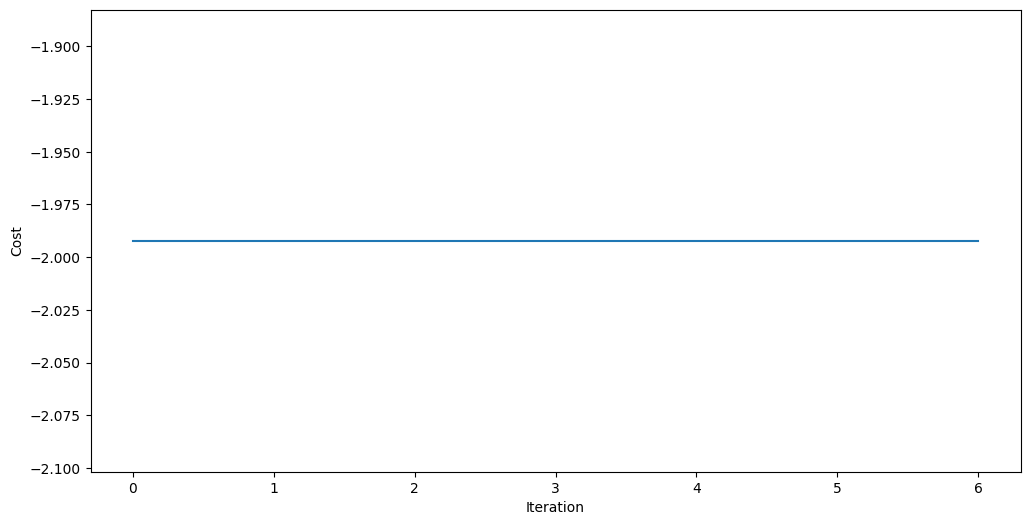

In [22]:
#TODO: Iteration plot not working - adjust how cost values are  getting in

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Analyzing the result

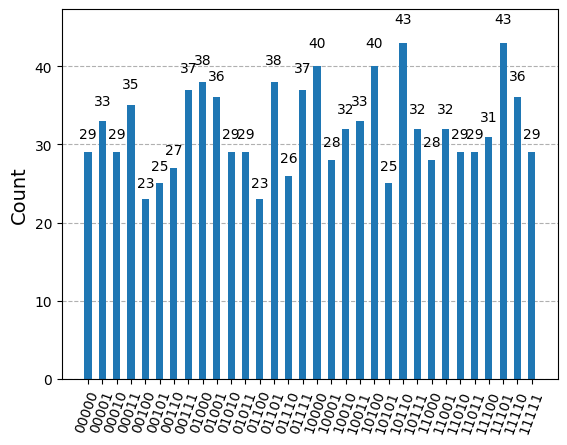

In [33]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

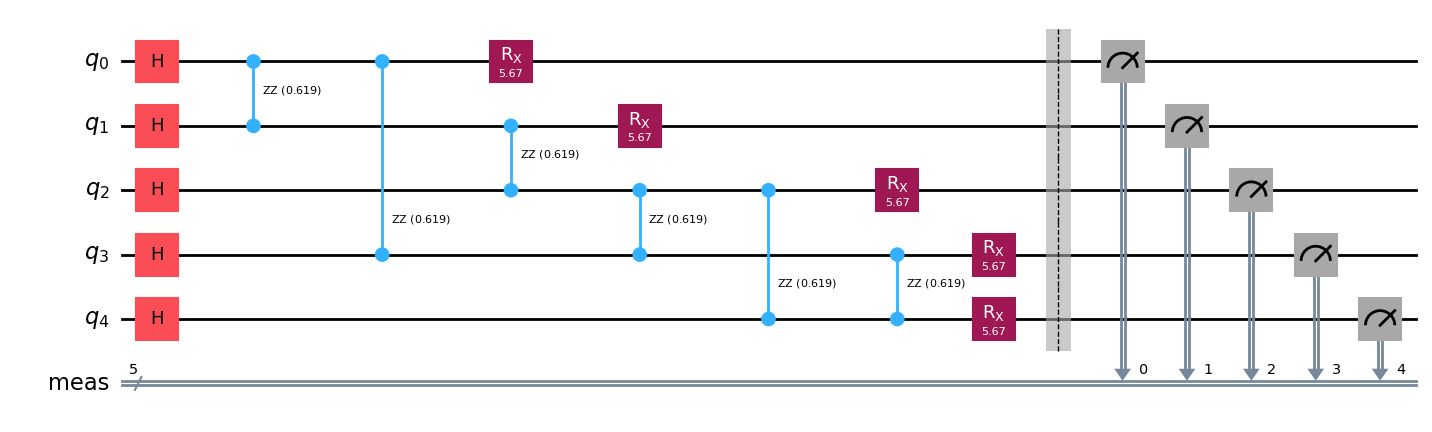

In [117]:
qc_res.draw('mpl')

In [1]:
import qiskit
qiskit.version.get_version_info()

'1.1.0'

In [2]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'